The purpose of this notebook is to perform exploratory data analysis with visualizations to better understand the data. This analysis is in progress and will continue to be updated.

### Mount Google Drive for file access

In [0]:
# mount gdrive for file access

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Load datasets collected using the API and the web scraper

In [0]:
import pandas as pd

# load API and scaped datasets
df_a = pd.read_csv('/content/gdrive/My Drive/Python/Mtn_proj_model/data/getRoutesData.csv', dtype='str')
df_s = pd.read_csv('/content/gdrive/My Drive/Python/Mtn_proj_model/data/scapedData_0-86891_fullset.csv', dtype='str')

### Drop columns that will not be used

In [0]:
# preview dataframes and drop columns that won't be used, including redundant columns
df_a = df_a.drop(['_id', 'imgMedium', 'imgSmall', 'imgSmallMed', 'imgSqSmall', 'url'], axis=1)
df_s = df_s.drop(['routeName', 'apScoreAvg', 'scoreStarsVotes', 'r_type', 'gradeYDS', 'gradeFr', 'gradeEwb', 'gradeUIAA', 'gradeZA', 'gradeBr', 'apScoreCount'], axis=1)

### Merge dataframes by 'id' column

In [0]:
# rename 'routeid' to 'id' in df2 to make merging simpler
df_s.rename(columns={'routeid':'id'}, inplace=True)

# set ids as indices
df_a.set_index('id', inplace=True)
df_s.set_index('id', inplace=True)

# merge dataframes by 'id'
df = pd.merge(df_a, df_s, on='id')
df = df.drop_duplicates()

# preview dataframe
df.head(1)

,latitude,location,longitude,name,pitches,rating,starVotes,stars,type,scoreStars,r_length,FA_data,page_views,page_view_rate,desc,locInfo,pro,commentList,apPopularityScore
id,,,,,,,,,,,,,,,,,,,
105906185,35.8734,"['Arkansas', ""Sam's Throne & Surroundings"", ""S...",-93.0472,Arkansas Roofs 101,1,5.10a,5,3.4,Trad,2.4,50 ft,['Jon Von Canon 3/91'],577.0,4/month,Climb the fistcrack 20 feet to the base of the...,At the right end of the Too Big to Finger Wall...,"Pro to 3.5 or 4"". Rap off trees if there aren...",[],0.34006


### Make a copy of dataframe and clean the data

In [0]:
import numpy as np

# modify and clean up data for analysis and plotting
df1 = df.copy()

# set all routes of multiple types to 'Mixed'
df1['type'][df1['type'].str.contains(',', na=False)] = 'Mixed'

# drop unit from page_view rate and rename column
df1['page_view_rate'] = df1['page_view_rate'].str.split('/').str[0]
df1.rename(columns={'page_view_rate':'views_per_month'}, inplace=True)

# drop unit from r_length rate and rename column
df1['r_length'][~df1['r_length'].str.contains('ft', na=False)] = np.nan
df1['r_length'] = df1['r_length'].str.split(' ft').str[0]
df1.rename(columns={'r_length':'length_ft'}, inplace=True)

# set dtypes
df1['views_per_month'] = df1['views_per_month'].astype(float)
df1['length_ft'] = df1['length_ft'].astype(float)
df1['page_views'] = df1['page_views'].astype(float)
df1['apPopularityScore'] = df1['apPopularityScore'].astype(float)
df1['stars'] = df1['stars'].astype(float)
df1['starVotes'] = df1['starVotes'].astype(float)
df1['scoreStars'] = df1['scoreStars'].astype(float)
df1['pitches'] = df1['pitches'].astype(float)
df1[['latitude', 'longitude']] = df1[['latitude', 'longitude']].astype(float)

# check df1 after cleaning
df1.head(1)


,latitude,location,longitude,name,pitches,rating,starVotes,stars,type,scoreStars,length_ft,FA_data,page_views,views_per_month,desc,locInfo,pro,commentList,apPopularityScore
id,,,,,,,,,,,,,,,,,,,
105906185,35.8734,"['Arkansas', ""Sam's Throne & Surroundings"", ""S...",-93.0472,Arkansas Roofs 101,1.0,5.10a,5.0,3.4,Trad,2.4,50.0,['Jon Von Canon 3/91'],577.0,4.0,Climb the fistcrack 20 feet to the base of the...,At the right end of the Too Big to Finger Wall...,"Pro to 3.5 or 4"". Rap off trees if there aren...",[],0.34006


### Plot a correlation heatmap of the numerical features

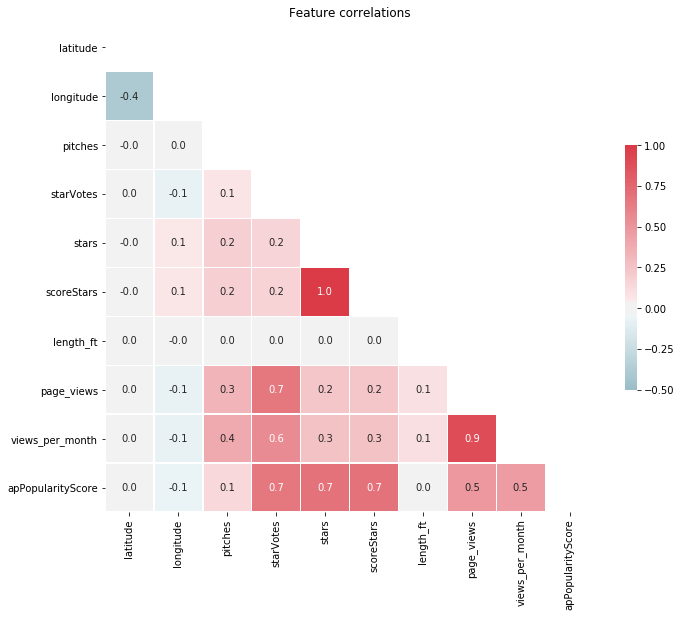

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# compute correlation matrix
corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm = sns.heatmap(corr, annot=True, fmt='.1f', mask=mask, cmap=cmap,
                 vmax=1, vmin=-0.5, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})

# add title
title = plt.title('Feature correlations')

There are correlations between *page_views*, *views_per_month*, *stars*, *scoreStars*, *starVotes*, and *apPopularityScore*. These make sense when considering popular routes.


#### Compare the *scoreStars* and *stars* ratings

It's not surprising that there is a strong correlation between scoreStars and stars, which seem to be based on four- and five-star systems, respectively.

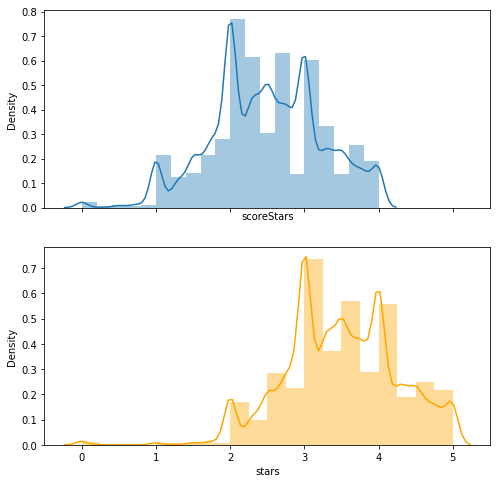

In [0]:
# create figure
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))

# plot score distributions for comparison
bins = 20
plt2 = sns.distplot(df1['scoreStars'].dropna(), bins=bins, ax=ax1)
plt1 = sns.distplot(df1['stars'], bins=bins, ax=ax2, color='orange')

# add y labels
label1 = ax1.set(ylabel='Density')
label2 = ax2.set(ylabel='Density')

The density estimate curves are nearly identical, just offset by one star. It seems likely that these features are redundant.

### Distribution of route lengths

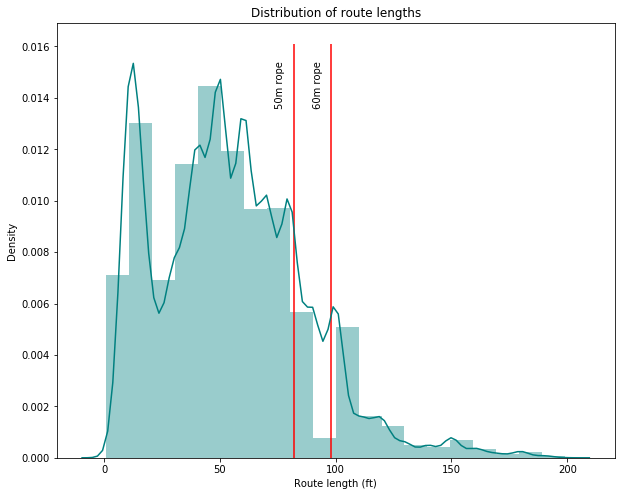

In [0]:
from matplotlib.pyplot import text

x50m = 82 # half of 50m rope in ft
x60m = 98 # half of 60m rope in ft

plt.figure(figsize=[10,8])

ax = sns.distplot(df1['length_ft'][(df1['length_ft'] < 200)], bins=20, color='teal')

ylims = ax.get_ylim()
lines = plt.vlines(x=[x50m,x60m], ymin=ylims[0], ymax=ylims[1], color = 'r')

lengths = ['50m','60m']
for i, x in enumerate([x50m, x60m]):
    text(x-8, ylims[1]*0.9, lengths[i] + ' rope', rotation=90, verticalalignment='center')
    
plt.title('Distribution of route lengths')
labels = ax.set(xlabel='Route length (ft)', ylabel='Density')

Note that there are sharp dropoffs in density at common rope lengths (see plot annotations). The red lines represent the maximum route lengths that each rope can be used on (to ascend and lower).

### Plot counts for each route type

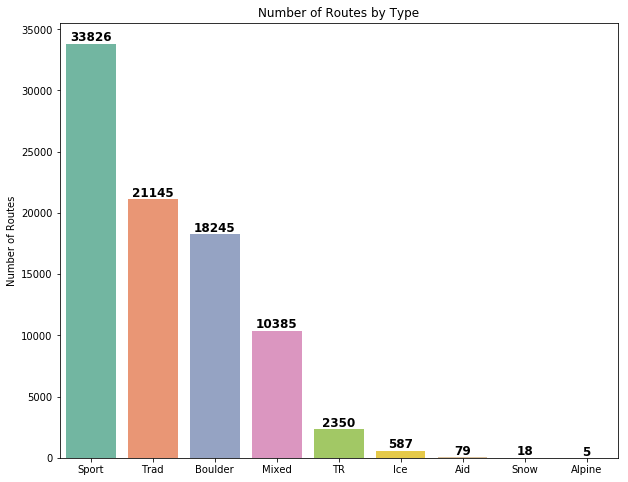

In [0]:
# create figure
plt.subplots(figsize=(10,8))

# get value counts and plot them, sorting by count value
counts = df1['type'].value_counts()
ax = sns.countplot(df1['type'], order=counts.index, palette='Set2')

# add values to plot to better quantification
pos = range(len(counts))
for tick,label in zip(pos,ax.get_xticklabels()):
   ax.text(pos[tick], counts[tick]+200, counts[tick], horizontalalignment='center', size='large', color='k', weight='semibold')

# add y-label and title
labels = ax.set(xlabel='', ylabel='Number of Routes')
title = plt.title('Number of Routes by Type')

### Generate an interactive heatmap out route locations

In [0]:
import folium
from folium import plugins
from folium.plugins import HeatMap

# Initialize map
map = folium.Map(location=[37.8139, -83.6279], zoom_start=6) 

# List comprehension to make out list of lists
gps_data = [[row['latitude'],row['longitude']] for index, row in df1.iterrows()]

# Plot it on the map
HeatMap(gps_data).add_to(map)

# Save the heatmap as an interactive html file
save_map = False
if save_map:
  map.save('/content/gdrive/My Drive/Python/Mtn_proj_model/data/routes_heatmap.html')

# Display the map (not working in Chrome)
display_map = False
if display_map:
  map

#### Display static image of interactive map

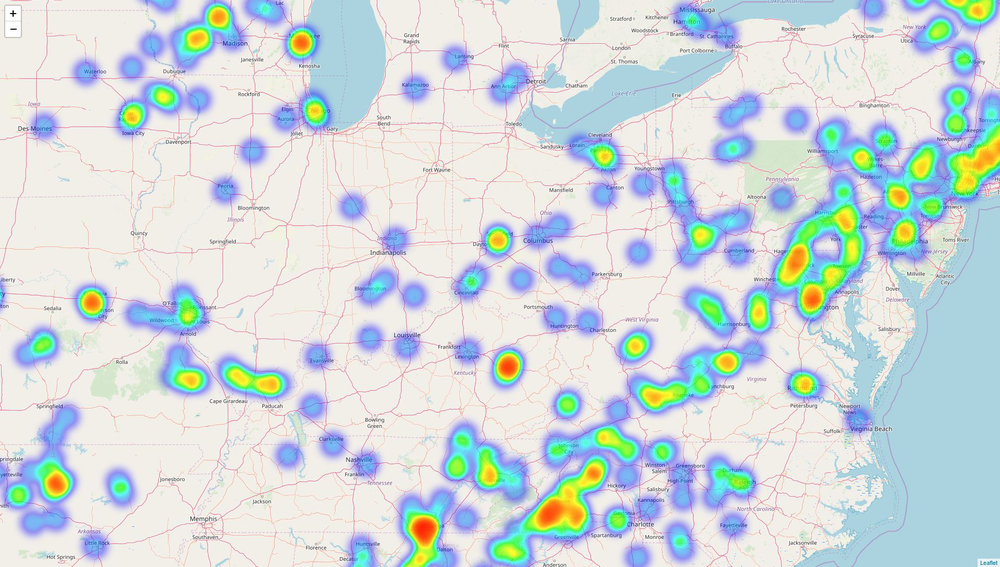

In [0]:
from PIL import Image

size = 1000,1000
image = Image.open('/content/gdrive/My Drive/Python/Mtn_proj_model/data/routes_heatmap_static.JPG')
image.thumbnail(size, Image.ANTIALIAS)
image

Note the red hot spot east of Lexington in the center.

### Visualize word and letter count distributions in comments

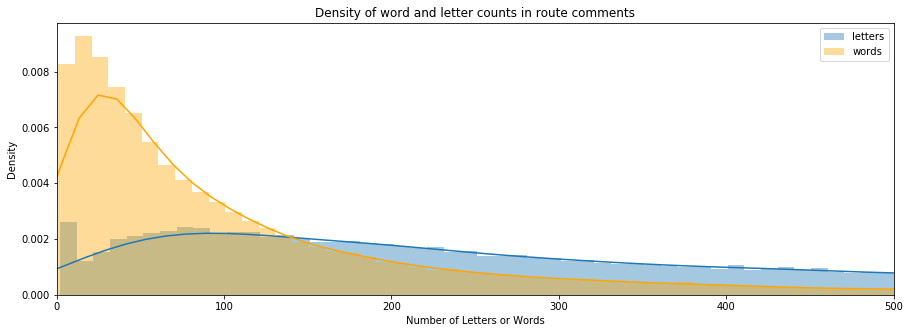

In [0]:
# make a copy of the main dataframe
df_text = df1[['commentList','scoreStars']].copy()

# remove list brackets and commas (list was converted to string when saved as csv)
df_text['commentList'] = df_text['commentList'].str.replace('[','').str.replace(']','').str.replace(',',' ').copy()

# drop rows with string length less than min_chars
min_chars = 1
mask = df_text['commentList'].str.len() >= min_chars
df_text = df_text.loc[mask]

# create figure
f, ax1 = plt.subplots(figsize=(15,5))

# plot letter counts
letter_count = df_text['commentList'].str.len()
plt1 = sns.distplot(letter_count[letter_count<1000], ax=ax1, label='letters', bins=100)
ax1.set_xlim(0, 500)

# plot word counts
word_count = df_text['commentList'].str.split(' ').str.len()
plt2 = sns.distplot(word_count[word_count<1000], ax=ax1, color='orange', label='words', bins=100)

# add legend, title, and labels
legend = plt.legend()
title = plt.title('Density of word and letter counts in route comments')
labels = ax1.set(xlabel='Number of Letters or Words', ylabel='Density')

### Create a word cloud of most frequently commented words

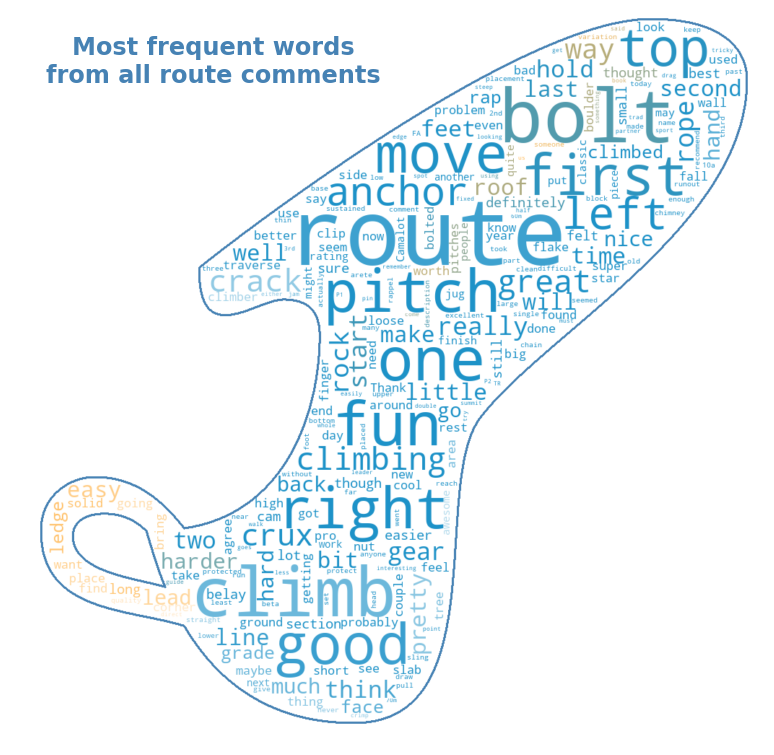

In [0]:
# make a word cloud of comments corpus

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from ast import literal_eval
import itertools

# join comments for all routes into word corpus
all_comm = df_text['commentList'].apply(literal_eval).to_list()
allwords = ' '.join(all_comm)

# create mask from PNG (source: https://icons8.com/icon/1584/climbing-shoes)
mask = np.array(Image.open('/content/gdrive/My Drive/Python/Mtn_proj_model/data/climbing_shoes_color_mask.png'))

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=400,
                      max_words=250,
                      background_color='white',
                      mask=mask,
                      collocations=False,
                      contour_width=2,
                      contour_color='steelblue')
wordcloud.generate(allwords)

# Map word colors from mask image and generate word cloud:
image_colors = ImageColorGenerator(mask)
f = plt.figure(figsize=[15,10])
ax = f.add_axes([0,0,1,1])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# add title
ax.annotate('Most frequent words\nfrom all route comments',
            xy=(0.25,0.9),
            xycoords='axes fraction',
            ha='center',
            fontsize=24,
            color='steelblue',
            weight='semibold')

# Display image
_ = plt.show()

### Plot distribution of route grades

#### Standardize grades using IRCRA grade scale

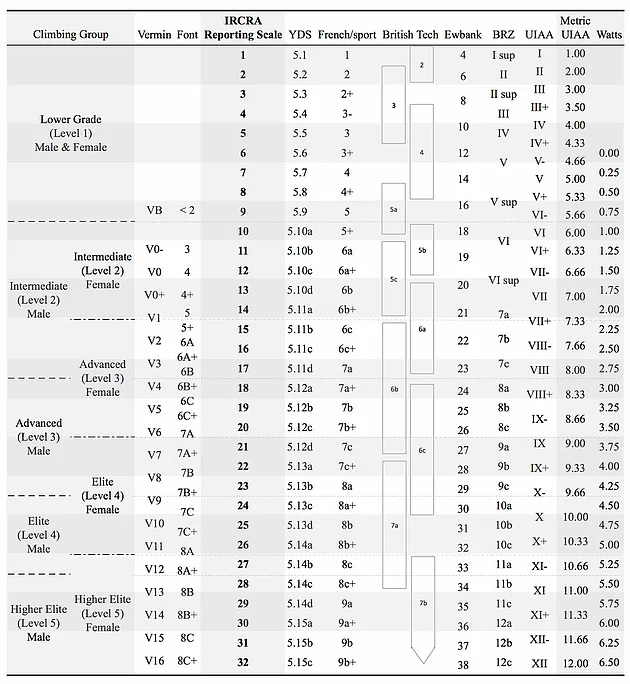

In [0]:
# Source: https://www.ircra.rocks/single-post/2016/09/12/Reporting-Grades-in-Climbing-Research

size = 1000,1000
image = Image.open('/content/gdrive/My Drive/Python/Mtn_proj_model/data/ircra_grades.jpg')
image.thumbnail(size, Image.ANTIALIAS)
image

Conversion of grades to numerical values will simplify analysis.

#### Convert YDS and V-grades into numerical grades

In [0]:
# make a copy of df1
df2 = df1.copy()

# fill NaN with zeros and initialize new columns
df2['rating_new'] = df2['rating'].fillna(0).copy()
df2['grade'] = ''
df2['IRCRA_grade'] = ''
df2['sketch_factor'] = ''


df2['rating_new'] = df2['rating_new'].str.replace('a/b','a').str.replace('b/c','b').str.replace('c/d','c').str.split(' ') # note that this creates NaN entries
df2['rating_new'].fillna(0, inplace=True)

# add grade if rating contains YDS of V-grade
# could also have tried filtering by 'type'
df2['grade'] = df2['rating_new'].apply(lambda  x : x[0] if type(x) == list and (x[0][:2] == '5.' or (x[0][0] == 'V' and x[0][1].isdigit())) else np.nan)

# define a 'sketch list', representing a route's risk or other danger; put these values in a column for possible future analysis (default is 'PG')
sketch_list = ['PG', 'PG13', 'PG-13', 'R', 'X']

# add sketch_factor if rating contains an item in sketch_list
df2['sketch_factor'] = df2['rating_new'].apply(lambda  x : x[1] if type(x) == list and (len(x) > 1 and x[1] in sketch_list) else x[2] if type(x) == list and (len(x) > 2 and x[2] in sketch_list) else 'PG')

# drop rows that are not YDS or V-grade, for simplicity; this will slightly sandbag or inflate some climbs
df2 = df2.dropna(subset=['grade'])

# drop rows that do not have grades
df2 = df2[df2['grade'] != ''].reset_index()

# drop +/- from end of V-grades
df2['grade'] = df2['grade'].apply(lambda  x : x[:-1] if x[0] == 'V' and (x[-1] == '+' or x[-1] == '-') else x)

# create IRCRA column and import dictionary to get values from grade keys
import json
with open('/content/gdrive/My Drive/Python/Mtn_proj_model/data/convert_grade.json') as f:
  convert_grade = json.load(f)
df2['IRCRA_grade'] = df2['grade'].apply(lambda  x : convert_grade[x])

#### Plot distribution of grades

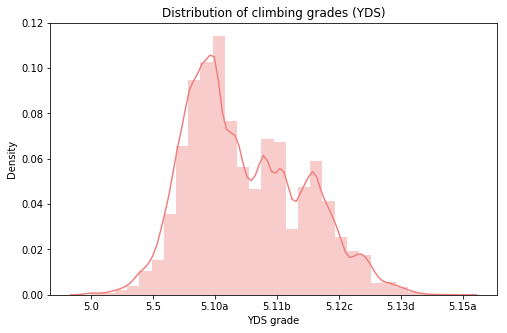

In [0]:
# create figure and generate plot
f, ax = plt.subplots(figsize=(8,5))
sns.distplot(df2['IRCRA_grade'], bins=30, color='lightcoral')

# create an inverse dictionary of grades to remap YDS grades to plot
with open('/content/gdrive/My Drive/Python/Mtn_proj_model/data/yds_ircra_dict.json') as f:
  yds_ircra_dict = json.load(f)
inv_map = {v: k for k, v in yds_ircra_dict.items()}

# replace x-axis IRCRA grades with YDS grades
ticks = ax.get_xticks()
inv_ticks = [inv_map[int(item)] if (item >= 0 and item <= 32) else '' for item in ticks]
new_ticks = ax.set_xticklabels(inv_ticks)

# add title and axes labels
title = plt.title('Distribution of climbing grades (YDS)')
labels = ax.set(xlabel='YDS grade', ylabel='Density')

### Plot a new correlation heatmap, including grades and route type

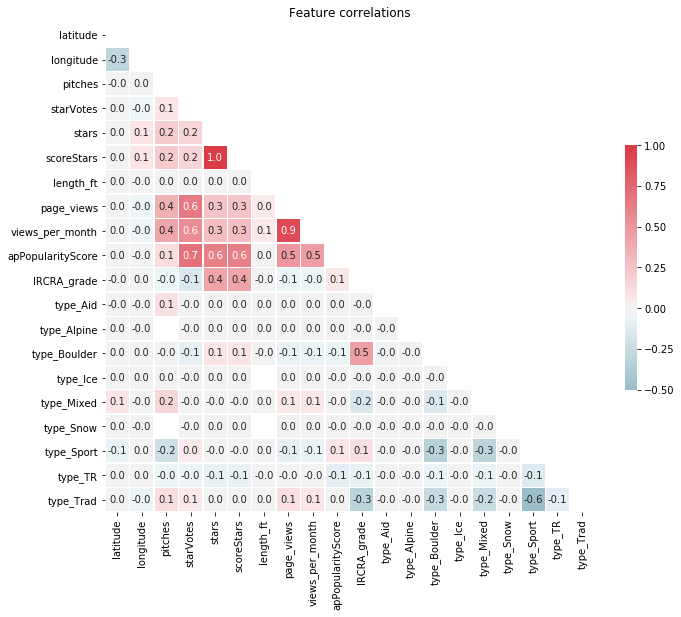

In [0]:
# correlation heatmap, including IRCRA grades and route type (move this up under first correlation heatmap?)

import seaborn as sns
import matplotlib.pyplot as plt

df2_dummies = pd.get_dummies(df2[['type']]) # took out sketch_factor
df2_dummies = pd.concat([df2, df2_dummies], axis=1)


corr = df2_dummies.corr()
#hm = sns.heatmap(corr, annot=True, fmt='.1f')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm = sns.heatmap(corr, annot=True, fmt='.1f', mask=mask, cmap=cmap,
                 vmax=1, vmin=-0.5, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})

# add title
title = plt.title('Feature correlations')


From this new correlation heatmap we can see that:

1.   Boulders are moderately correlated with a higher IRCRA grade compared to other climbing types. This makes sense since the easiest boulder problems start in the equivalent 5.10+ range, and the largest peak in the climbing grade density plot above is centered on 5.10a.
2.   Trad routes have a weak negative correlation with grade. All other things equal, carrying, selecting, and placing gear typically makes trad routes more difficult than climbing sport using quickdraws.
3.   Sport and trad routes have a moderate negative correlation.
4.   IRCRA grade has a low/moderate correlation with the route score.



### Plot IRCRA grade vs. score for various climbing types

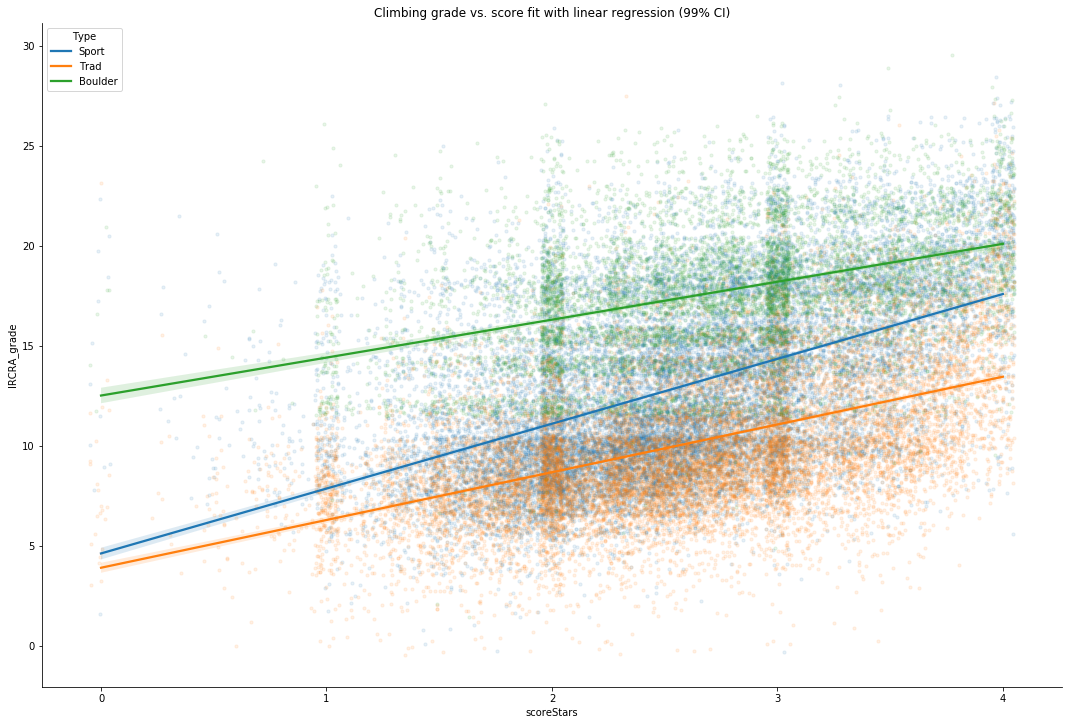

In [0]:
# create a linear regression plot
g = sns.lmplot(x="scoreStars",
           y="IRCRA_grade",
           data=df2_dummies[(df2_dummies['type_Trad']==1) | (df2_dummies['type_Sport']==1) | (df2_dummies['type_Boulder']==1)],
           hue='type',
           x_jitter=0.05,
           y_jitter=0.5,
           height=10,
           aspect=1.5,
           scatter_kws={'alpha':0.1, 's':10},
           truncate=True,
           legend_out=False,
           ci=99)

# add title
ax = plt.gca()
t = ax.set_title('Climbing grade vs. score fit with linear regression (99% CI)') # CI estimated by bootstrapping

# add legend
plt.legend(title='Type', loc='upper left', labels=['Sport', 'Trad', 'Boulder'])
plt.show(g)



Note the higher density of ratings at integer values.